# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os
import re
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import tensorflow as tf
import Audio_functions as af
import librosa
import UNet
import Dataset
import Utils

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Get the variables and data ready

In [ ]:
#  Locate the data to use
#  Locate the model checkpoint to load
local = False
checkpoint = '8/8-13'

if local:
    model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'
    mix_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/train_sup/Mixed'
    voice_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/train_sup/Voice'
else:
    model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'    
    mix_folder = 'C:/Users/Toby/CHiME3/data/audio/16kHz/isolated/tr05_caf_simu'
    voice_folder = 'C:/Users/Toby/CHiME3/data/audio/16kHz/isolated/tr05_org'

In [4]:
checkpoint = '8/8-13'
model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'
mix_folder = 'C:/Users/Toby/CHiME3/data/audio/16kHz/isolated/tr05_bus_simu'
voice_folder = 'C:/Users/Toby/CHiME3/data/audio/16kHz/isolated/tr05_org'

In [21]:
#  Set other variables
sample_rate=16384
n_fft=1024
fft_hop=256
n_channels=1
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=False
batch_size = 10
shuffle=True
n_shuffle=10

In [22]:
# Data pipeline functions

def zip_files(directory_a, directory_b):
    """
    Takes in two directories (a and b) and returns an array, where each row is a pair of matching file paths, 
    one from each directory, with directory a in col 0 and directory b in col 1
    """

    filelist_a = [f for f in os.listdir(directory_a) if os.path.isfile(os.path.join(directory_a, f)) and re.search('CH0', f) is None]
    filelist_b = [f for f in os.listdir(directory_b) if os.path.isfile(os.path.join(directory_b, f)) and re.search('CH0', f) is None]

    zipped_list = list()

    for file_a in filelist_a:
        for file_b in filelist_b:
            if file_a[:13] == file_b[:13] and (file_a[17:] == file_b[17:] or len(file_a)!=len(file_b)):
                zipped_list.append((str(directory_a + '/' + file_a), str(directory_b + '/' + file_b)))
                if len(file_a) == len(file_b):
                    filelist_b.remove(file_b)
                break
    
    zipped_list = np.array(zipped_list)                

    return zipped_list

def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       n_channels,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       normalise):

    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:,0],zipped_files[:,1]))
        .map(partial(read_audio_pair,
                     sample_rate=sample_rate), 
             num_parallel_calls=n_parallel_readers)
        .map(Utils.partial_argv(af.compute_spectrogram,
                                n_fft=n_fft,
                                fft_hop=fft_hop,
                                n_channels=n_channels,
                                normalise=normalise),
             num_parallel_calls=n_parallel_readers)
        .map(Utils.partial_argv(af.extract_spectrogram_patches,
                                n_fft=n_fft,
                                n_channels=n_channels,
                                patch_window=patch_window,
                                patch_hop=patch_hop,))
        .flat_map(Utils.zip_tensor_slices)).batch(batch_size).shuffle(n_shuffle)

def read_audio_pair(path_a, path_b, sample_rate):
    """
    Takes in the path of two audio files and the required output sample rate,
    returns a tuple of tensors of the wave form of the audio files.
    """
    def read_audio_py(py_path):

        mono, _ = librosa.load(py_path, sr=sample_rate, mono=True)
        return np.expand_dims(mono, 1)


    return (tf.py_func(read_audio_py, [path_a], tf.float32, stateful=False),
            tf.py_func(read_audio_py, [path_b], tf.float32, stateful=False))

In [23]:
# Prepare the data pipeline

zipped_files  = zip_files(mix_folder, voice_folder)

data = get_paired_dataset(zipped_files,
                          sample_rate,
                          n_fft,
                          fft_hop,
                          n_channels,
                          patch_window,
                          patch_hop,
                          n_parallel_readers,
                          normalise)

In [8]:
data

<ShuffleDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2)), types: (tf.float32, tf.float32)>

### Define the model structure

In [24]:
tf.reset_default_graph()
sess = tf.Session()

mixed, voice = data.make_one_shot_iterator().get_next()

In [25]:
# Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed[:, :, 1:, 0], 3)
mixed_phase = tf.expand_dims(mixed[:, :, 1:, 1], 3)
voice_mag = tf.expand_dims(voice[:, :, 1:, 0], 3)

# Build U-Net model
print('Creating model')
model = UNet.UNetModel(mixed_mag, voice_mag, mixed_phase, 'unet', is_training, name='U_Net_Model')

Creating model


### Load the saved weights

In [26]:
print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints\8/8-13


### Run a batch

In [27]:
mixture_mag, mix_phase_mag, voice_mag, voice_est_mag = sess.run([model.mixed, model.mixed_phase, model.voice,
                                                                  model.gen_voice], {model.is_training:False})
voice_est_wave = list()
voice_wave = list()
mix_wave = list()

for i in range(voice_mag.shape[0]):
    voice_est_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))
    # Should we use voice or the original audio? (Might be hard to split into matching patches)
    voice_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_mag[i, :, :, :]).T, n_fft,
                                                fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))
    
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mixture_mag[i, :, :, :]).T, n_fft,
                                              fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))

### Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [28]:
len(voice_est_wave)

10

In [29]:
#  The original mixture
ipd.Audio(mix_wave[0], rate=sample_rate)

In [30]:
#  The original isolated voice
ipd.Audio(voice_wave[0], rate=sample_rate)

In [31]:
#  The estimated isolated voice produced by the network
ipd.Audio(voice_est_wave[0], rate=sample_rate)

In [32]:
len(voice_est_wave[0])

65280

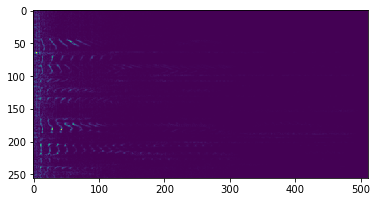

In [17]:
plt.imshow(voice_est_mag[0,:,:,0])

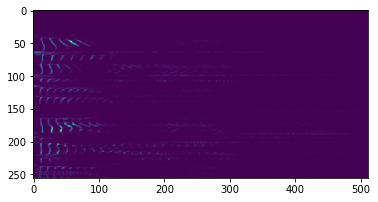

In [18]:
plt.imshow(voice_mag[0,:,:,0])

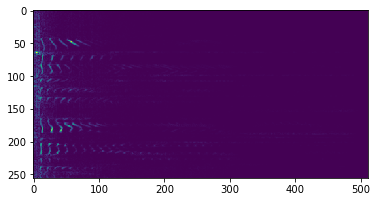

In [19]:
plt.imshow(mixture_mag[0,:,:,0])

In [ ]:
voice_est_mag.shape

In [ ]:
sess.run(model.voice_mask_unet.encoder.l1[0])

In [ ]:
sess.run(model.voice_mask_unet.encoder.l1[0])

In [ ]:
def get_weights():
  return [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('kernel:0')]

In [ ]:
get_weights()

In [ ]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [ ]:
tf.initialize_all_variables()

In [34]:
voice_mag[0,:,:,0].shape

(256, 512)